In [2]:
from __future__ import print_function
from __future__ import unicode_literals
import pynini
import re
from string import punctuation, ascii_letters

In [3]:
output_alphabet = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine","ten", 
                   "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen",
                   "eighteen", "nineteen", 
                   "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty","ninty", 
                   "hundred"]

input_alphabet = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

eps = '<eps>' # both input table and output table should include this

# HW2
## fst: Number-name generator

You will build a finite-state transducer that takes a number between 0 and 999 and turn it into words. For example, it will take 123 and produce "one hundred twenty three". Note that you will need to create a new symbol table for the output, which will contain words like "one" and "hundred". For the input, just use the ascii.syms.txt symbol table.

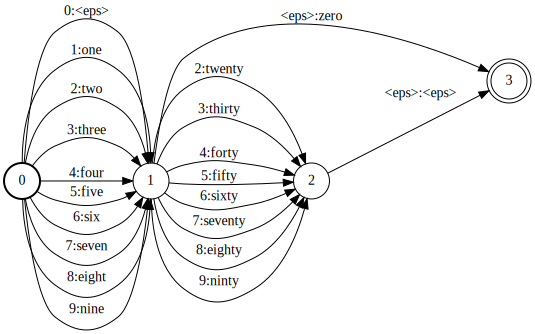

In [89]:
fst = pynini.Fst()
for _ in range(0,4):
    fst.add_state()
fst.set_start(0)
fst.set_final(3)

input_table = pynini.SymbolTable()
output_table = pynini.SymbolTable()

input_table.add_symbol(eps, key=0)
output_table.add_symbol(eps, key=0)
output_table.add_symbol("offset") #How do you show two symbol tables with same index? (input, output)

for ch in input_alphabet:
    input_table.add_symbol(ch)
for ch in output_alphabet:
    output_table.add_symbol(ch)

fst.set_input_symbols(input_table)
fst.set_output_symbols(output_table)

#Add eps arcs
fst.add_arc(0, pynini.Arc(1, 0, 0, 1))
#fst.add_arc(1, pynini.Arc(0, 0, 0, 2))
fst.add_arc(2, pynini.Arc(0, 0, 0, 3))

#Add single digit arcs
for i in range(1,10):
    fst.add_arc(0, pynini.Arc(input_table.find(input_alphabet[i]), output_table.find(output_alphabet[i]), 0, 1))
fst.add_arc(1, pynini.Arc(0, 2, 0, 3))

#Add tens digit arcs
for i in range(2,10):
    fst.add_arc(1, pynini.Arc(input_table.find(input_alphabet[i]), output_table.find(output_alphabet[i+18]), 0, 2))

#Add hundreds digit arcs

fst
#epsilon_machine = pynini.epsilon_machine()
#fst.union(epsilon_machine)

In [92]:
fst_acceptor = pynini.acceptor("5", token_type = input_table)
solution = pynini.compose(fst_acceptor, fst)
solution.stringify(token_type = output_table).replace("<eps>","").replace(" ","")


'fivezero'

The issues with a number-name translator that will need to be solved are as follows:

### #1. A digit is translated to a different word based on whether it's in the ones, tens, or hundreds place.

If we read left to right, it is difficult to deduce the tens-power until we reach the end of the string, but if we read backwards, we can figure that out as we go.

### #2. Special cases

#### 2.a Zero
    
#### 2.b Teens
    
Epsilon transitions can be used to consume multiple inputs for a single output (i.e. 11 -> eleven), as seen in the Tokenization example in the openfst docs: (http://www.openfst.org/twiki/bin/view/FST/FstExamples).

<span style="color:red">Self Comments:</span>